In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.dates as mdates

In [17]:
# Load the dataset
df = pd.read_csv('data/raw_analyst_ratings.csv')

# Display the first few rows in a nice format
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 4000)        # Wider display
pd.set_option('display.max_rows', 10)       # Limit number of rows displayed

# Display the first few rows
print(df.head())

   Unnamed: 0                                           headline                                                url          publisher                       date stock
0           0            Stocks That Hit 52-Week Highs On Friday  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights  2020-06-05 10:30:54-04:00     A
1           1         Stocks That Hit 52-Week Highs On Wednesday  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights  2020-06-03 10:45:20-04:00     A
2           2                      71 Biggest Movers From Friday  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin  2020-05-26 04:30:07-04:00     A
3           3       46 Stocks Moving In Friday's Mid-Day Session  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin  2020-05-22 12:45:06-04:00     A
4           4  B of A Securities Maintains Neutral on Agilent...  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer  2020-05-22 11:38:59-04:0

In [4]:
df['headline_length'] = df['headline'].apply(len)
headline_length_stats = df['headline_length'].describe()
print(headline_length_stats)

count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


In [5]:
publisher_counts = df['publisher'].value_counts()
print(publisher_counts)

publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
                      ...  
Matthew Ely               1
Frank Ochoa               1
Jeremie Capron            1
Marvin Dumont             1
Igor Gonta                1
Name: count, Length: 1034, dtype: int64


In [6]:

# Drop any rows with NaT in the 'date' column
df = df.dropna(subset=['date'])


In [7]:
print(df['date'].isna().sum())

0


Count of NaT values: 1351341
datetime64[ns, UTC-04:00]


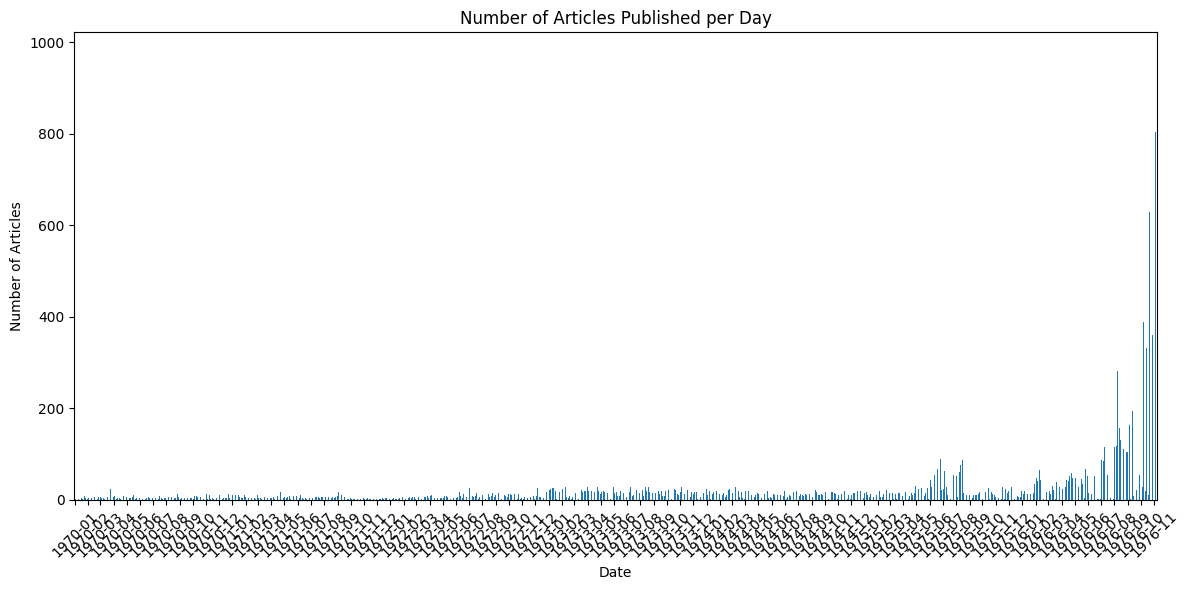

In [20]:


# Convert the 'date' column to datetime, removing timezone information
df['date'] = pd.to_datetime(df['date'].str.replace(r'(\+\d{2}:\d{2}|\-\d{2}:\d{2})', ''), errors='coerce')

# Confirm the conversion
print(f"Count of NaT values: {df['date'].isna().sum()}")
print(df['date'].dtype)

# Handle timezone if needed
if df['date'].dt.tz is not None:
    df['date'] = df['date'].dt.tz_convert('UTC')  # Convert to UTC if desired
    # or remove timezone: df['date'] = df['date'].dt.tz_localize(None)

# Count articles published per date
articles_per_date = df['date'].dt.date.value_counts().sort_index()

# Plot the results
plt.figure(figsize=(12, 6))
articles_per_date.plot(kind='bar')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Set date formatting
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.title('Number of Articles Published per Day')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [24]:
# Group by month and count articles
df['date'] = df['date'].dt.tz_localize(None)

# Group by month and count articles
df['month_year'] = df['date'].dt.to_period('M')
monthly_counts = df['month_year'].value_counts().sort_index()

# Convert to DataFrame for better handling
monthly_counts_df = monthly_counts.reset_index()
monthly_counts_df.columns = ['Month_Year', 'Article_Count']

In [27]:
df['month_year'] = df['date'].dt.to_period('M')
monthly_counts = df['month_year'].value_counts().sort_index()

# Convert to DataFrame for better handling
monthly_counts_df = monthly_counts.reset_index()
monthly_counts_df.columns = ['Month_Year', 'Article_Count']
[59]
# Count articles per day
daily_counts = df.groupby(df['date'].dt.date).size().reset_index(name='Article_Count')
# Calculate the average number of articles per day
average_count = daily_counts['Article_Count'].mean()

# Define a threshold (e.g., days with more than 1.5 times the average)
threshold = 1.5 * average_count
high_frequency_days = daily_counts[daily_counts['Article_Count'] > threshold]

# Filter for high-frequency days
high_frequency_days_sorted = high_frequency_days.sort_values(by='Article_Count', ascending=False)

top_100_days = high_frequency_days_sorted.head(100)

# Print the results
print("Top 100 Days with Increased News Frequency:")
print(top_100_days)

Top 100 Days with Increased News Frequency:
            date  Article_Count
2412  2020-03-12            973
2495  2020-06-05            932
2500  2020-06-10            807
2499  2020-06-09            803
2498  2020-06-08            765
...          ...            ...
2053  2018-12-19             87
2376  2020-01-30             86
2374  2020-01-28             86
2379  2020-02-04             85
2310  2019-11-12             85

[100 rows x 2 columns]


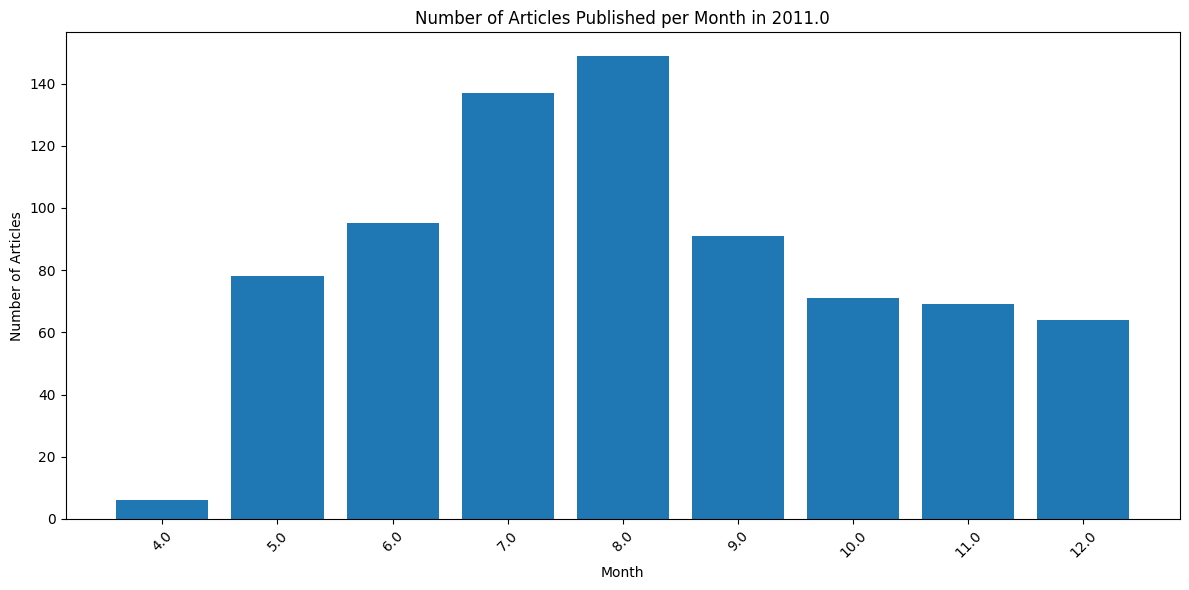

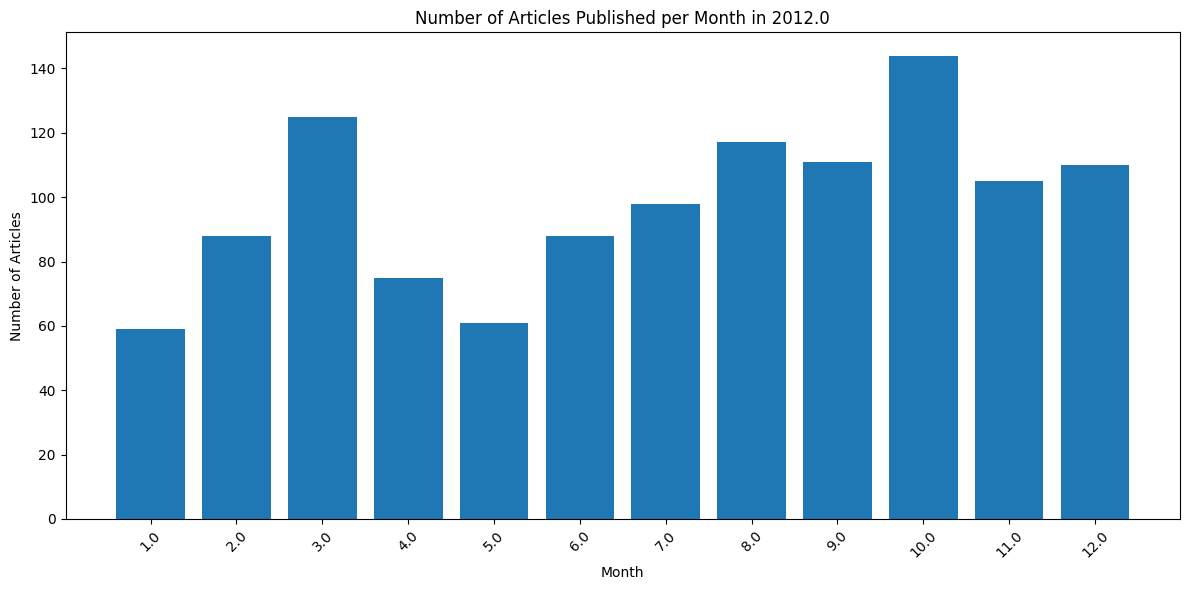

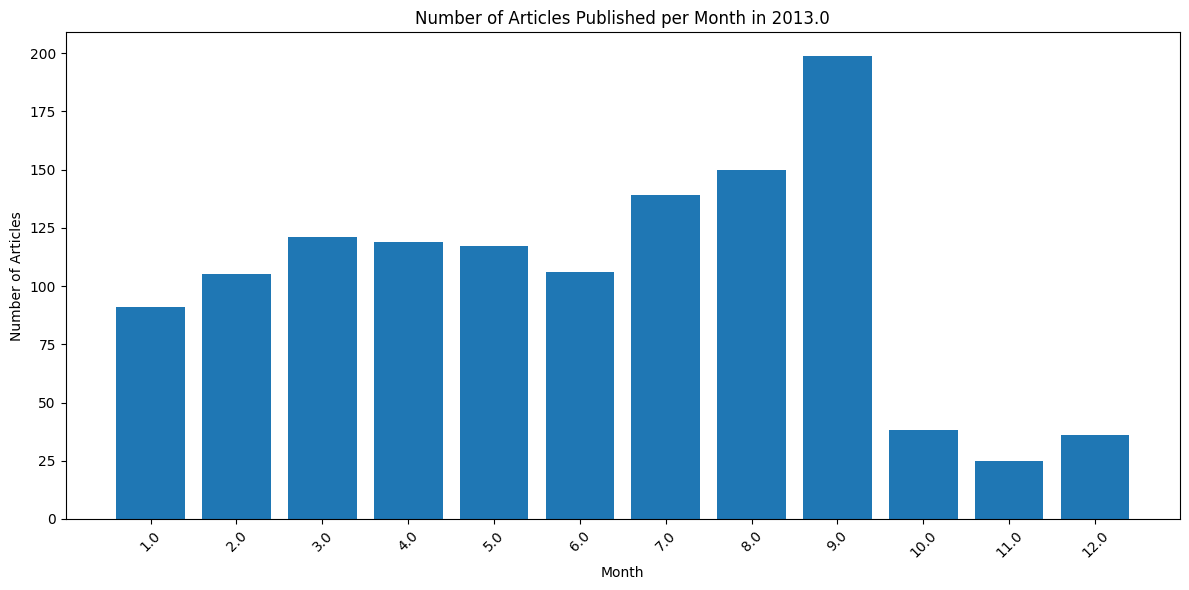

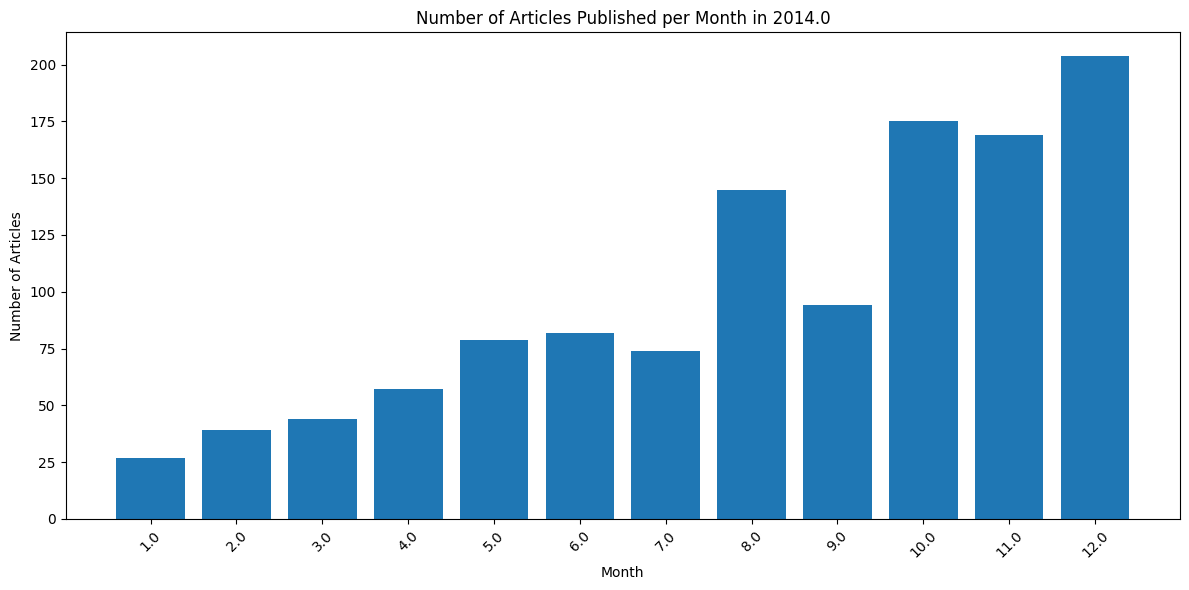

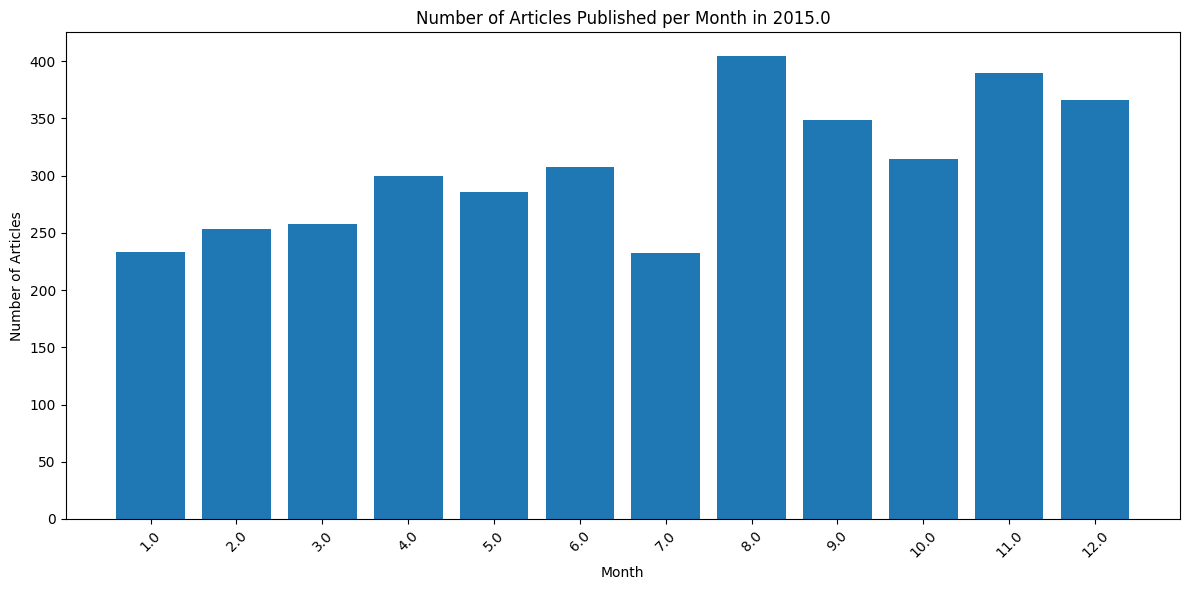

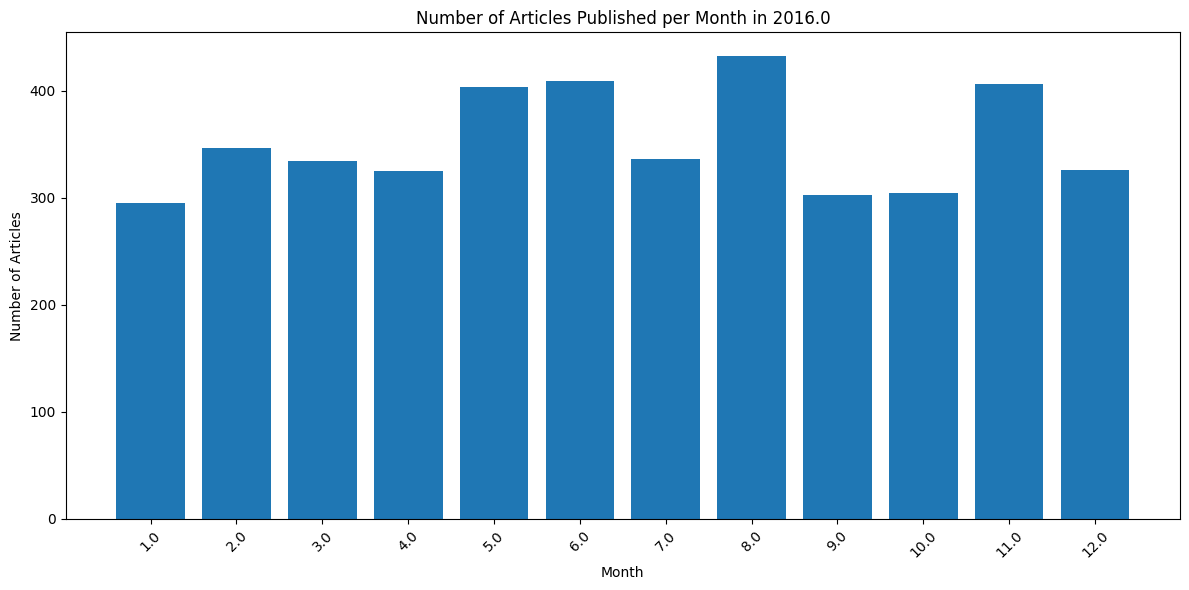

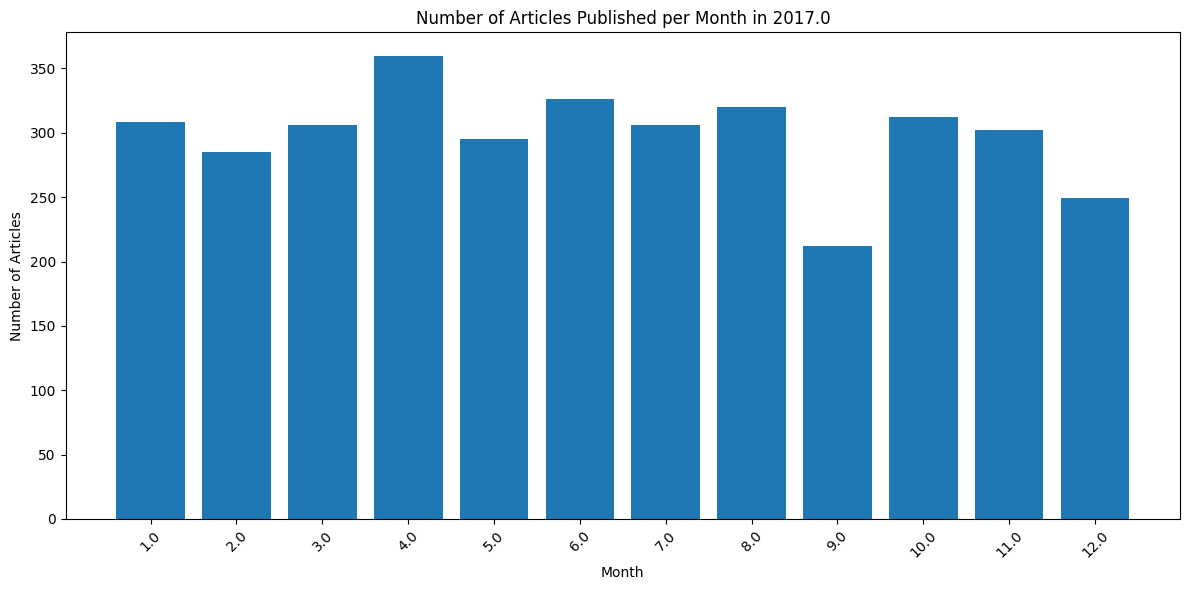

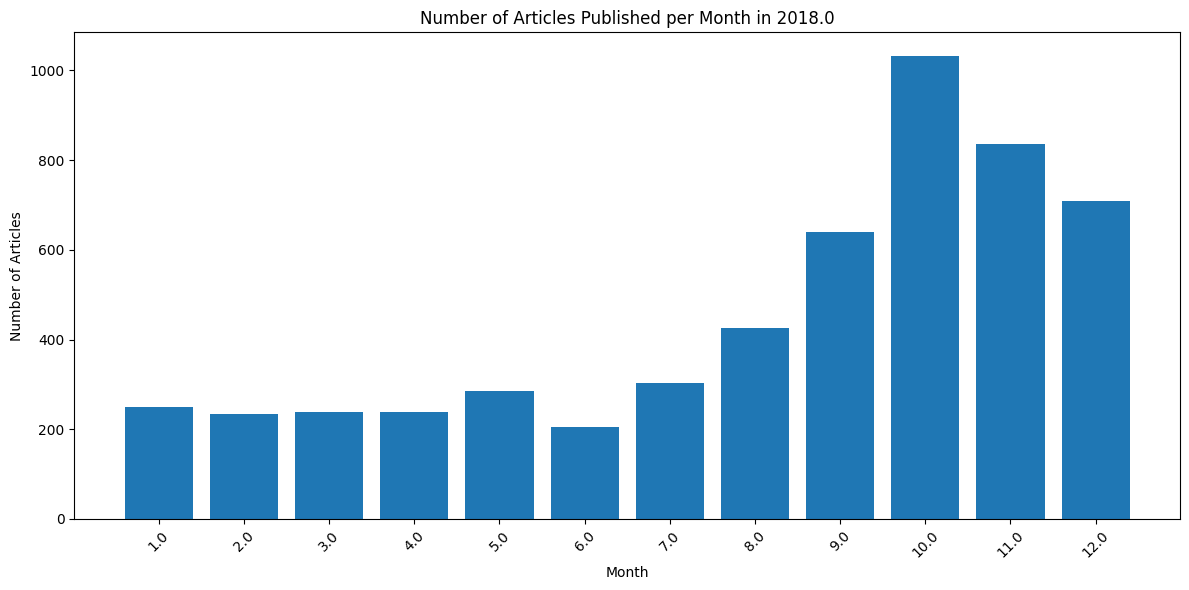

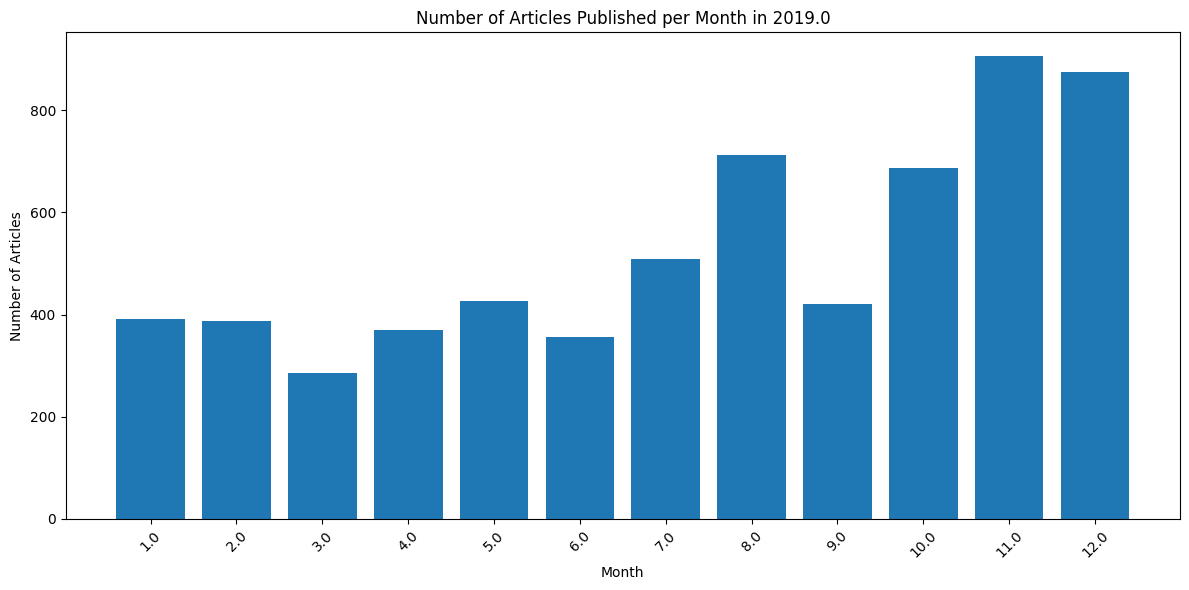

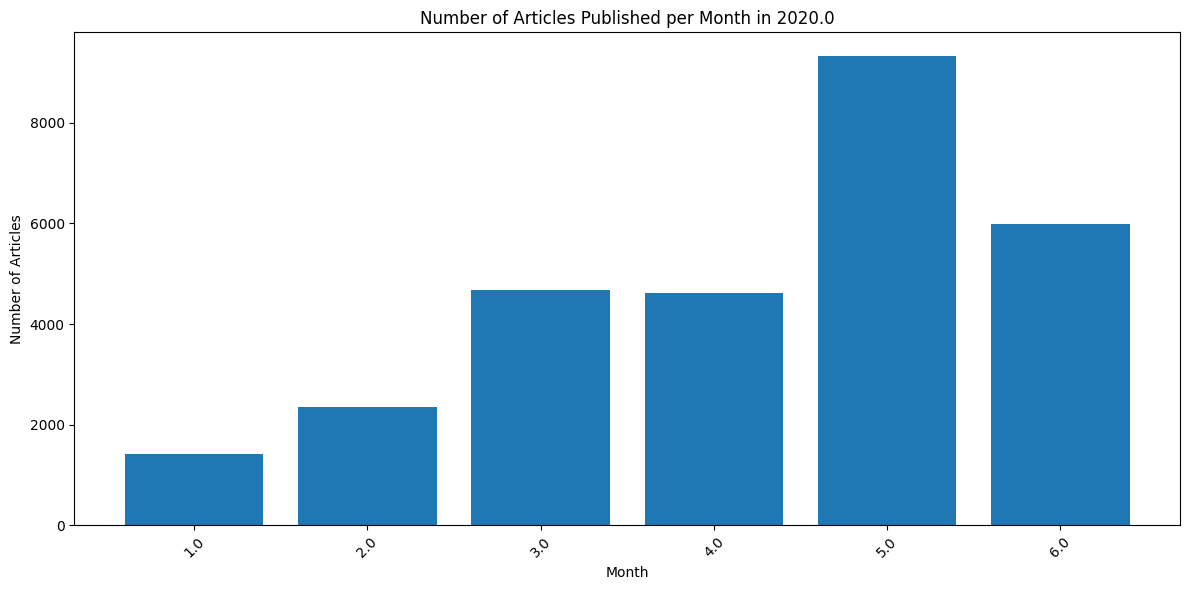

In [28]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
monthly_counts = df.groupby(['year', 'month']).size().reset_index(name='Article_Count')
years = monthly_counts['year'].unique()

for year in years:
    # Filter data for the specific year
    monthly_data = monthly_counts[monthly_counts['year'] == year]
    
    # Create a bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(monthly_data['month'].astype(str), monthly_data['Article_Count'])
    plt.title(f'Number of Articles Published per Month in {year}')
    plt.xlabel('Month')
    plt.ylabel('Number of Articles')
    plt.xticks(monthly_data['month'].astype(str), rotation=45)
    plt.tight_layout()
    plt.show()

In [29]:
import re

def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\W', ' ', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply preprocessing
df['clean_headline'] = df['headline'].apply(preprocess_text)

keywords = [
    "fda approval",
    "price target",
    "earnings report",
    "merger",
    "acquisition",
    "product launch",
    "regulatory approval"
]

def extract_topics(headline, keywords):
    found_topics = []
    for keyword in keywords:
        if keyword in headline:
            found_topics.append(keyword)
            break  # Stop after the first match
    return found_topics if found_topics else [None]  # Return None if no match

# Use apply to extract topics for each headline
df['extracted_topics'] = df['clean_headline'].apply(lambda x: extract_topics(x, keywords))

# Count occurrences of each topic
topic_counts = df['extracted_topics'].explode().value_counts()
print(topic_counts)

extracted_topics
price target           47628
acquisition             8774
merger                  5613
fda approval            1546
earnings report         1520
regulatory approval      319
product launch            74
Name: count, dtype: int64


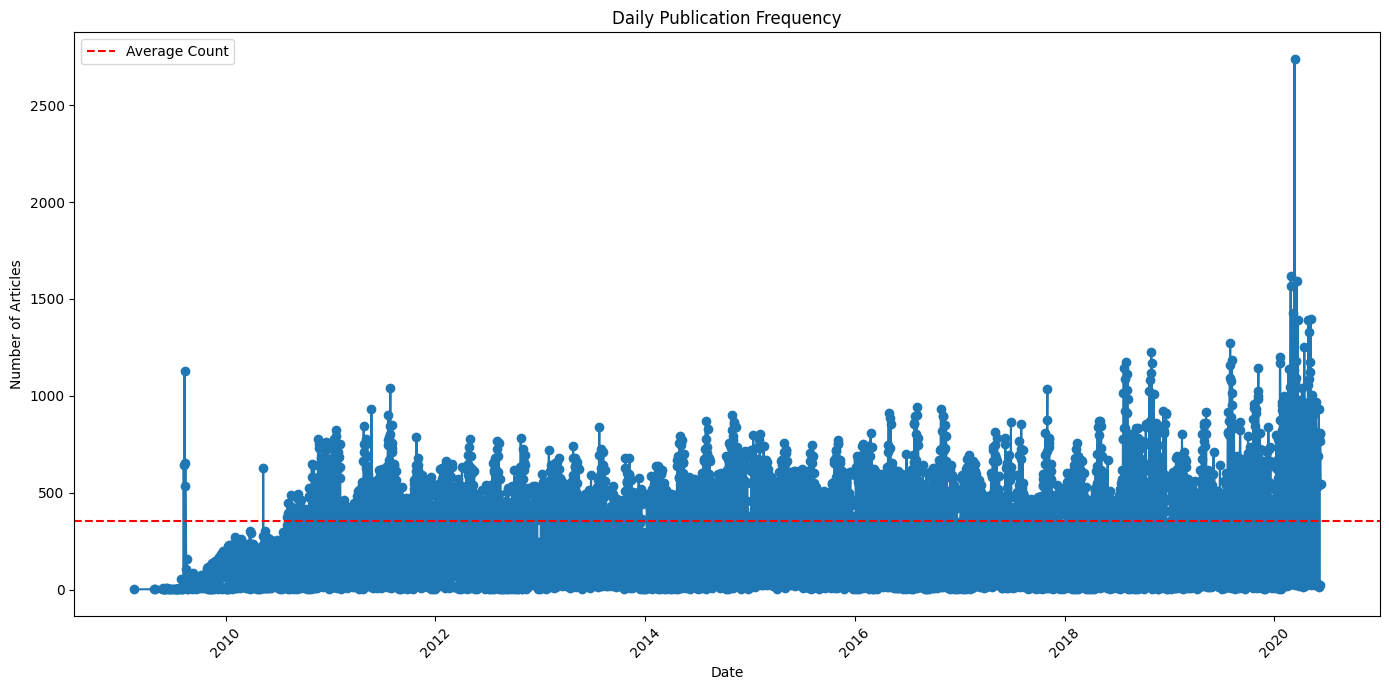

In [69]:
df['date'] = pd.to_datetime(df['date'])
df['date_only'] = df['date'].dt.date
df['time_only'] = df['date'].dt.time
daily_counts = df.groupby('date_only').size().reset_index(name='Article_Count')
average_count = daily_counts['Article_Count'].mean()
threshold = 1.5 * average_count
spike_days = daily_counts[daily_counts['Article_Count'] > threshold]
time_counts = df.groupby(df['time_only']).size().reset_index(name='Article_Count')
import matplotlib.pyplot as plt

# Plot daily counts
plt.figure(figsize=(14, 7))
plt.plot(daily_counts['date_only'], daily_counts['Article_Count'], marker='o')
plt.axhline(y=average_count, color='r', linestyle='--', label='Average Count')
plt.title('Daily Publication Frequency')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
plt.figure(figsize=(14, 7))
plt.plot(daily_counts['date_only'], daily_counts['Article_Count'], marker='o', label='Daily Count')
plt.scatter(spike_days['date_only'], spike_days['Article_Count'], color='red', label='Spikes')
plt.axhline(y=average_count, color='r', linestyle='--', label='Average Count')
plt.title('Publication Frequency with Spikes Highlighted')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

KeyError: 'date_only'

<Figure size 1400x700 with 0 Axes>

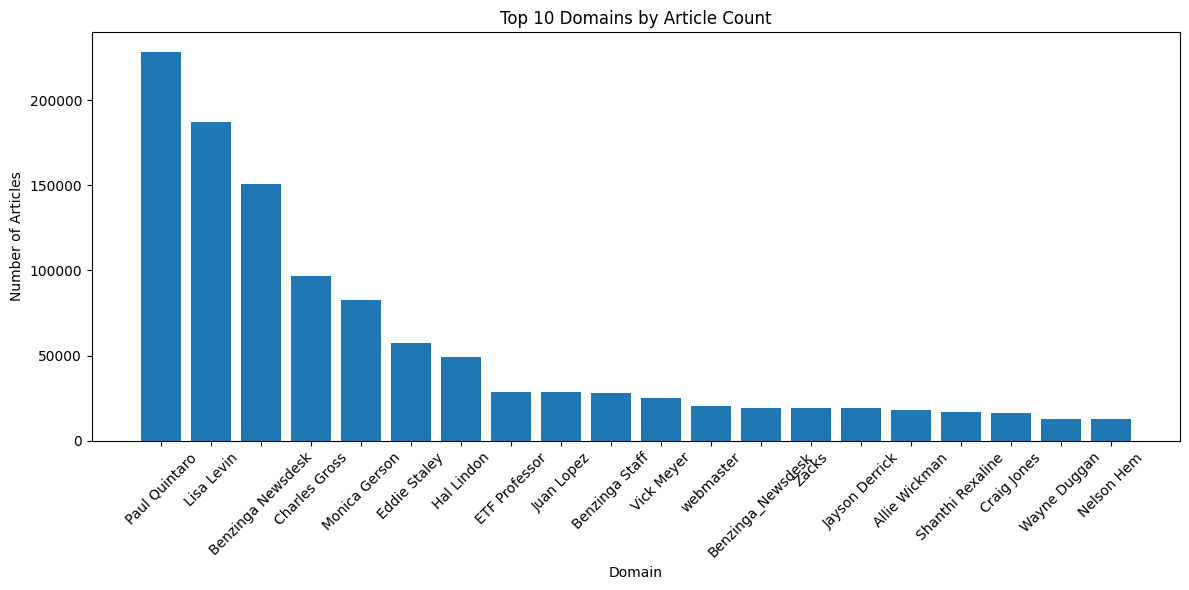

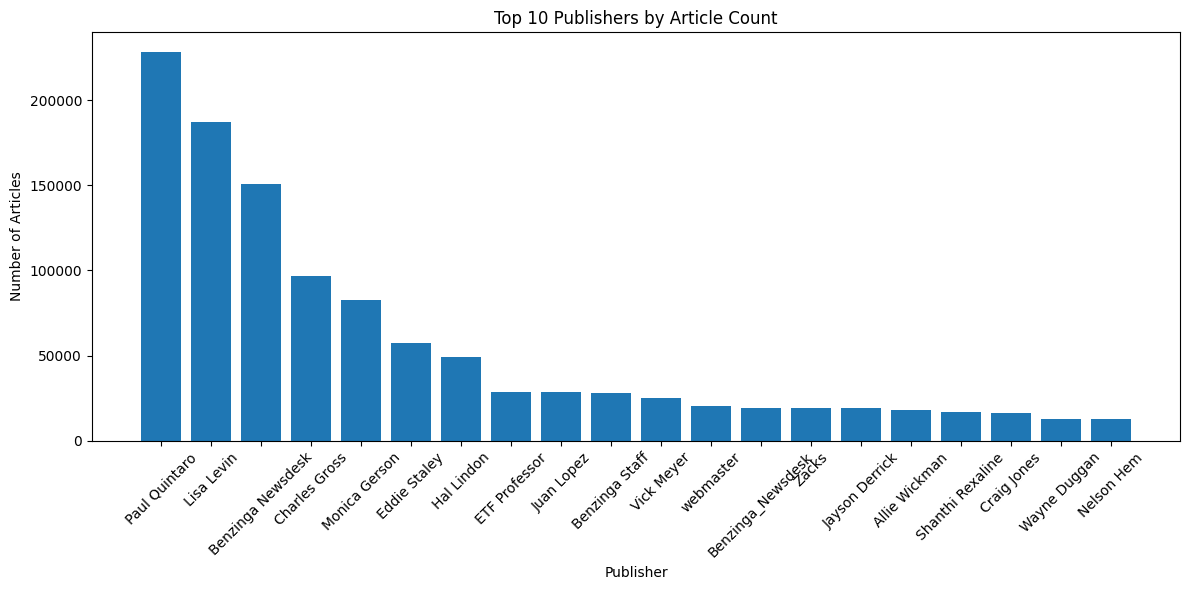

In [78]:

df['publisher'] = df['publisher'].astype(str) 
publisher_counts = df['publisher'].value_counts().reset_index()
publisher_counts.columns = ['Publisher', 'Article_Count']
import pandas as pd

# Function to extract domain from email
def extract_domain(publisher):
    if '@' in publisher:
        return publisher.split('@')[-1]
    return publisher  # Return the name if not an email

# Apply the function to create a new column for domains
df['domain'] = df['publisher'].apply(extract_domain)

domain_counts = df['domain'].value_counts().reset_index()
domain_counts.columns = ['Domain', 'Article_Count']
# Plotting top domains
plt.figure(figsize=(12, 6))
plt.bar(domain_counts['Domain'].head(20), domain_counts['Article_Count'].head(20))
plt.title('Top 20 Domains by Article Count')
plt.xlabel('Domain')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Plotting top publishers
plt.figure(figsize=(12, 6))
plt.bar(publisher_counts['Publisher'].head(20), publisher_counts['Article_Count'].head(20))
plt.title('Top 20 Publishers by Article Count')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()